# RL Trading Strategy with OHLCV Data
Using Open, High, Low, Close, and Volume data for a richer state representation.

In [1]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import random

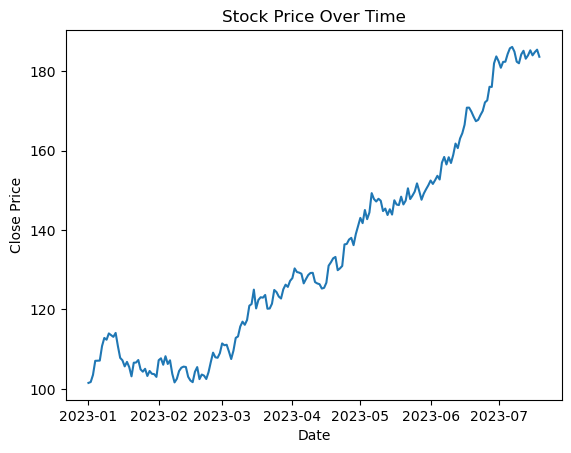

In [2]:
# Load data
df = pd.read_csv("sample_stock_data_full.csv")
df['Date'] = pd.to_datetime(df['Date'])
data = df[['Open', 'High', 'Low', 'Close', 'Volume']].values

plt.plot(df['Date'], df['Close'])
plt.title("Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [3]:
def format_price(n):
    return f"${n:.2f}"

def get_state(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else np.vstack([data[0]] * -d + data[0:t + 1].tolist())
    diffs = block[1:] - block[:-1]
    flat_state = diffs.flatten()
    return flat_state

In [4]:
class DQNAgent:
    def __init__(self, state_size):
        self.state_size = state_size
        self.action_size = 3  # Hold, Buy, Sell
        self.memory = deque(maxlen=1000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = np.reshape(state, [1, self.state_size])
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state.reshape(1, -1), verbose=0)[0])
            target_f = self.model.predict(state.reshape(1, -1), verbose=0)
            target_f[0][action] = target
            self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [11]:
# Training loop
window_size = 10
agent = DQNAgent(window_size * data.shape[1] - data.shape[1])  # n-1 diffs, each with 5 features

episodes = 5
batch_size = 16

for e in range(episodes):
    print(f"\nEpisode {e+1}/{episodes}")
    state = get_state(data, 0, window_size)
    total_profit = 0
    agent.inventory = []

    for t in range(window_size, len(data)):
        action = agent.act(state)
        print(f"action is {action}")
        next_state = get_state(data, t, window_size)
        reward = 0

        if action == 1:  # Buy
            agent.inventory.append(data[t][3])  # Use Close price
            print(f"Buy at {format_price(data[t][3])}")

        elif action == 2 and len(agent.inventory) > 0:  # Sell
            bought_price = agent.inventory.pop(0)
            reward = max(data[t][3] - bought_price, 0)
            total_profit += data[t][3] - bought_price
            print(f"Sell at {format_price(data[t][3])} | Profit: {format_price(data[t][3] - bought_price)}")

        done = t == len(data) - 1
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if done:
            print(f"Total Profit: {format_price(total_profit)}")

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

C:\Users\ravee\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Episode 1/5
action is 0
action is 0
action is 1
Buy at $114.09
action is 0
action is 0
action is 1
Buy at $107.19
action is 2
Sell at $105.66 | Profit: $-8.43
action is 2
Sell at $106.79 | Profit: $-0.40
action is 1
Buy at $105.47
action is 0
action is 1
Buy at $106.58
action is 2
Sell at $106.63 | Profit: $1.16
action is 0
action is 2
Sell at $104.91 | Profit: $-1.67
action is 1
Buy at $104.32
action is 0
action is 0
action is 0
action is 2
Sell at $103.79 | Profit: $-0.53
action is 2
action is 0
action is 1
Buy at $107.21
action is 1
Buy at $107.69
action is 0
action is 2
Sell at $108.22 | Profit: $1.01
action is 0
action is 1
Buy at $107.19
action is 0
action is 2
Sell at $101.62 | Profit: $-6.07
action is 0
action is 0
action is 1
Buy at $105.33
action is 1
Buy at $105.60
action is 2
Sell at $105.50 | Profit: $-1.69
action is 0
action is 0
action is 2
Sell at $101.68 | Profit: $-3.65
action is 1
Buy at $104.29
action is 1
Buy at $105.48
action is 1
Buy at $102.45
action is 0
actio

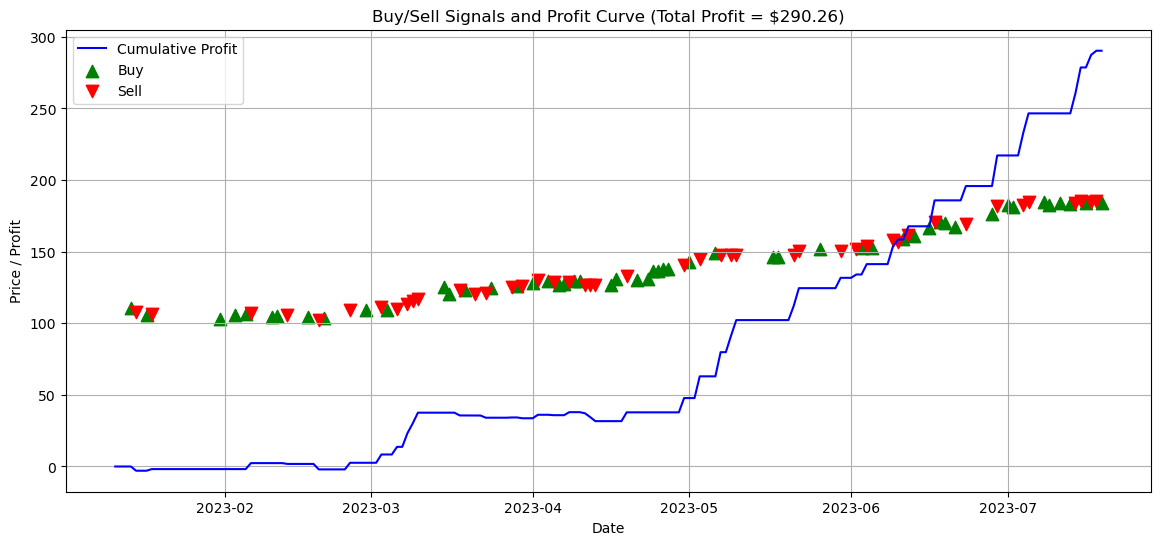

In [12]:
# Evaluate and plot with Buy/Sell signals
buy_points = []
sell_points = []
profits = []

state = get_state(data, 0, window_size)
inventory = []
total_profit = 0

for t in range(window_size, len(data)):
    action = agent.act(state)
    next_state = get_state(data, t, window_size)

    if action == 1:  # Buy
        inventory.append(data[t])
        buy_points.append((t, data[t][3]))  # Close price

    elif action == 2 and len(inventory) > 0:  # Sell
        bought_price = inventory.pop(0)
        profit = data[t][3] - bought_price[3]
        total_profit += profit
        sell_points.append((t, data[t][3]))

    profits.append(total_profit)  # Append total_profit at every time step
    state = next_state

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(df['Date'][window_size:], profits, label='Cumulative Profit', color='blue')
plt.scatter(df['Date'][[p[0] for p in buy_points]], [p[1] for p in buy_points], marker='^', color='green', label='Buy', s=80)
plt.scatter(df['Date'][[p[0] for p in sell_points]], [p[1] for p in sell_points], marker='v', color='red', label='Sell', s=80)
plt.xlabel("Date")
plt.ylabel("Price / Profit")
plt.title(f"Buy/Sell Signals and Profit Curve (Total Profit = {format_price(total_profit)})")
plt.legend()
plt.grid(True)
plt.show()
